In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation, PCA
from scipy.cluster.hierarchy import ward, dendrogram

import pyLDAvis
import warnings




In [ ]:
aiart_path = "/Users/roryoflynn/Desktop/TEXT MINING/MOD1ASSGINMENT/LDF-NKW-AiArt.csv"
art_path   = "/Users/roryoflynn/Desktop/TEXT MINING/MOD1ASSGINMENT/LDF-NKW-Art.csv"

aiart_df = pd.read_csv(aiart_path)
art_df   = pd.read_csv(art_path)

# # theres an extra index in my dfs
# aiart_df.drop(aiart_df.columns[0], axis=1, inplace=True)
# art_df.drop(art_df.columns[0], axis=1, inplace=True)

# Combine them
combined_df = pd.concat([aiart_df, art_df], ignore_index=True)
print("Total documents in combined data:", len(combined_df))
print(combined_df.head(3))

# Export combinedDF as Mod2CombinedCleaned Df.
combined_df.to_csv("/Users/roryoflynn/Desktop/TEXT MINING/MOD1ASSGINMENT/Mod2CombinedCleaned.csv", index=False)


Total documents in combined data: 703
   Unnamed: 0  LABEL                                            content
0           0  AIArt                        dont make me tap the sign  
1           1  AIArt  rcomics mods say  is welcome and tell  folks t...
2           2  AIArt                        another failed witch hunt  


In [ ]:
## TF IDF IT
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(combined_df['content'])
vocab = vectorizer.get_feature_names_out()
print("TF-IDF shape:", X_tfidf.shape)

#TF-IDF matrix to a DataFrame
DT = pd.DataFrame(X_tfidf.toarray(), columns=vocab)

#get rid of useless terms that are extremely rare (< 3 docs) or overly common (in > 80% of docs)
min_docs = 3
max_pct  = 0.8

doc_count = (DT > 0).sum(axis=0)
total_docs = DT.shape[0]

keep_cols = []
for col in DT.columns:
    freq = doc_count[col]
    if freq >= min_docs and freq <= max_pct * total_docs:
        keep_cols.append(col)

DT = DT[keep_cols]
print("After filtering columns, shape:", DT.shape)

# Remove columns with non-alphabetic characters or too short names (<= 3 characters)
for col in list(DT.columns):
    if re.search(r'[^a-zA-Z]', col) or len(col) <= 3:
        DT.drop(col, axis=1, inplace=True)

print("After removing short/odd columns, shape:", DT.shape)

# Final numeric matrix
X_filtered = DT.values


TF-IDF shape: (703, 9226)
After filtering columns, shape: (703, 2660)
After removing short/odd columns, shape: (703, 2482)


In [ ]:
## PCA Bc its big as heck
from sklearn.decomposition import PCA

n_components = 100 # or 20, 100, etc.
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_filtered)
print("PCA reduced shape:", X_pca.shape)


PCA reduced shape: (703, 100)


In [ ]:
#then finding Best Number of Clusters Using Sil. scores  & the elbow method.
k_values = [2, 3, 4, 5]
best_k = None
best_sil = -999

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels, metric='cosine')
    print(f"K={k}, silhouette={sil:.3f}")
    if sil > best_sil:
        best_sil = sil
        best_k = k

print(f"\nBest K by silhouette is {best_k} (score={best_sil:.3f})")

K=2, silhouette=0.022
K=3, silhouette=0.067
K=4, silhouette=0.053
K=5, silhouette=0.042

Best K by silhouette is 3 (score=0.067)


In [6]:
kmeans_model = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_pca)
combined_df['KMeans_Cluster'] = kmeans_labels + 1  # To label clusters starting from 1

print("\nCrosstab of LABEL vs. KMeans_Cluster:")
print(pd.crosstab(combined_df['LABEL'], combined_df['KMeans_Cluster']))

print("Cluster sizes:", np.bincount(kmeans_labels))


Crosstab of LABEL vs. KMeans_Cluster:
KMeans_Cluster   1    2    3
LABEL                       
AIART            0    5    0
AIArt           10  130  344
ART              0   54  110
Art              0   23   27
Cluster sizes: [ 10 212 481]


In [7]:
import numpy as np
print("Cluster sizes:", np.bincount(kmeans_labels))


Cluster sizes: [ 10 212 481]


In [8]:
cluster_data = pd.DataFrame(X_filtered, columns=DT.columns)
cluster_data['cluster'] = kmeans_labels

def top_words_in_cluster(df, cluster_id, top_n=10):
    subset = df[df['cluster'] == cluster_id].drop('cluster', axis=1)
    avg_tfidf = subset.mean(axis=0)
    return avg_tfidf.sort_values(ascending=False).head(top_n)

for c_id in range(best_k):
    print(f"\nCluster {c_id+1} top words:")
    print(top_words_in_cluster(cluster_data, c_id, 20))



Cluster 1 top words:
data          0.202506
work          0.087047
ethical       0.069534
consent       0.067887
scraping      0.058051
doesnt        0.056034
copyright     0.053079
training      0.042349
patterns      0.040507
theft         0.039156
like          0.038632
book          0.038469
automation    0.037503
students      0.036484
used          0.034910
public        0.032657
project       0.031113
looking       0.030898
dataset       0.030777
prevent       0.030634
dtype: float64

Cluster 2 top words:
like       0.070965
just       0.052590
work       0.047671
dont       0.045352
really     0.044727
tablet     0.042501
love       0.041311
good       0.040713
people     0.040328
want       0.030502
make       0.030299
think      0.030076
ipad       0.029083
great      0.028120
time       0.026433
artists    0.023829
amazing    0.023617
look       0.023614
looks      0.023601
draw       0.023505
dtype: float64

Cluster 3 top words:
like       0.014167
just       0.013349
peop

In [9]:
for c in range(1, best_k+1):
    subset = combined_df[combined_df['KMeans_Cluster'] == c]
    print(f"\n--- K-Means Cluster {c} ---")
    print(f"Number of docs: {len(subset)}")
    for i, row in subset.head(3).iterrows():
        print(f"Doc idx: {i}, Label: {row['LABEL']}")
        print("Content:", row['content'][:200], "...\n")



--- K-Means Cluster 1 ---
Number of docs: 10
Doc idx: 101, Label: AIArt
Content:  is theft people cannot respond to this post and remain ethically consistent i do not consent to you reading and interpreting these words if you take any data out of this post even to argue with or do ...

Doc idx: 209, Label: AIArt
Content: how to opt out of instagrams data scraping   ...

Doc idx: 221, Label: AIArt
Content: im proconsent and  while it might not prevent job loss i believe its reasonable and respectable that people would like the option to opt out of having their work used for training  without having to r ...


--- K-Means Cluster 2 ---
Number of docs: 212
Doc idx: 3, Label: AIArt
Content: reasons why society should ban the printing press xb xb it will destroy monks jobs copying books is a highly specialized skill and we shouldnt just allow a machine to do that who even asked for the pr ...

Doc idx: 33, Label: AIArt
Content: im a fulltime   i hate it ive been a professional  for about a

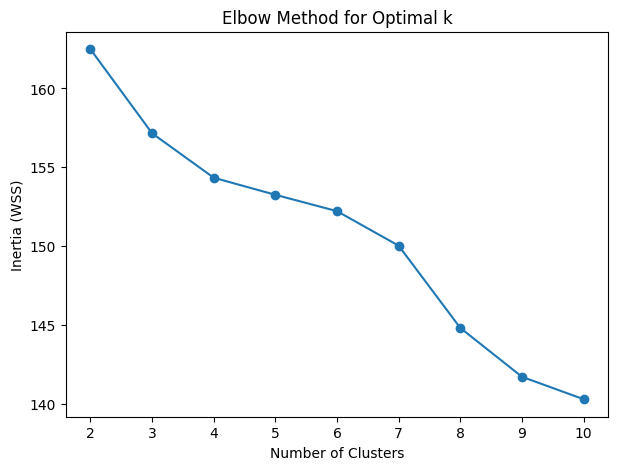

In [10]:
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(list(k_range), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WSS)")
plt.show()

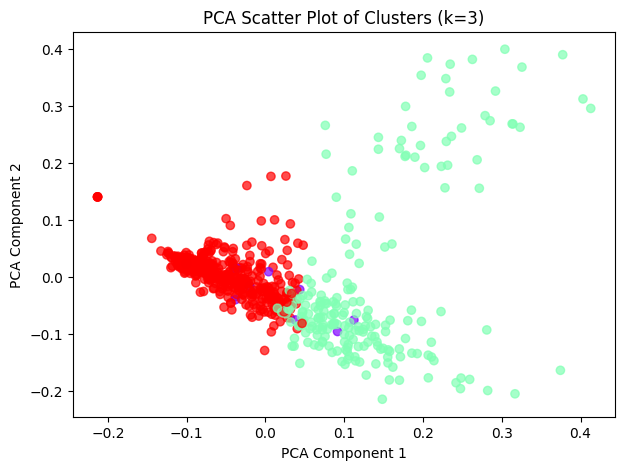

In [11]:
plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='rainbow', alpha=0.7)
plt.title(f"PCA Scatter Plot of Clusters (k={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

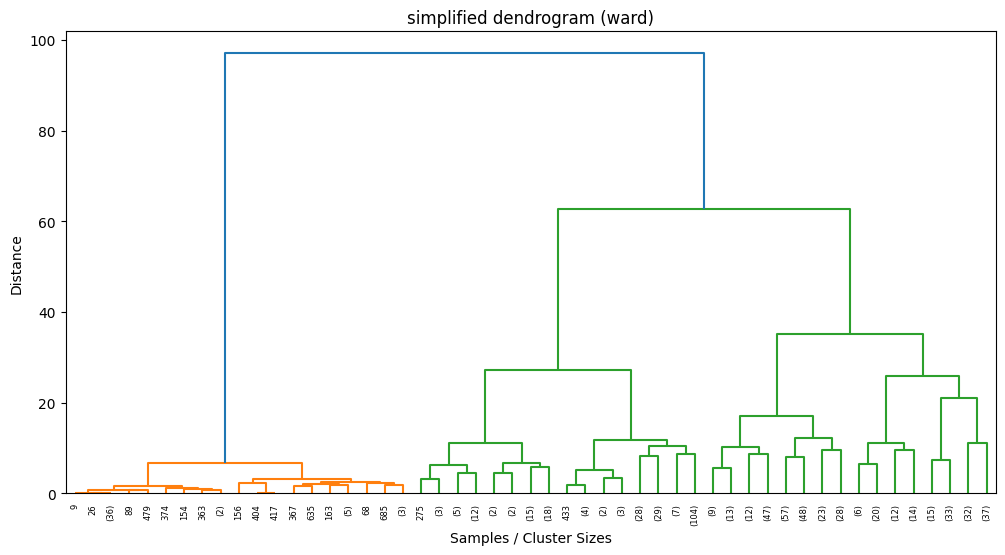

In [ ]:
# cosine similarity on the PCA-reduced data w Ward's method.
cos_dist = 1 - cosine_similarity(X_pca)
linkage_matrix = ward(cos_dist)
plt.figure(figsize=(12, 6))
# 'truncate_mode' is set to 'level' to show only the top levels
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("simplified dendrogram (ward)")
plt.xlabel("Samples / Cluster Sizes")
plt.ylabel("Distance")
plt.show()


--- K-Means Cluster 1 ---
Number of docs: 10


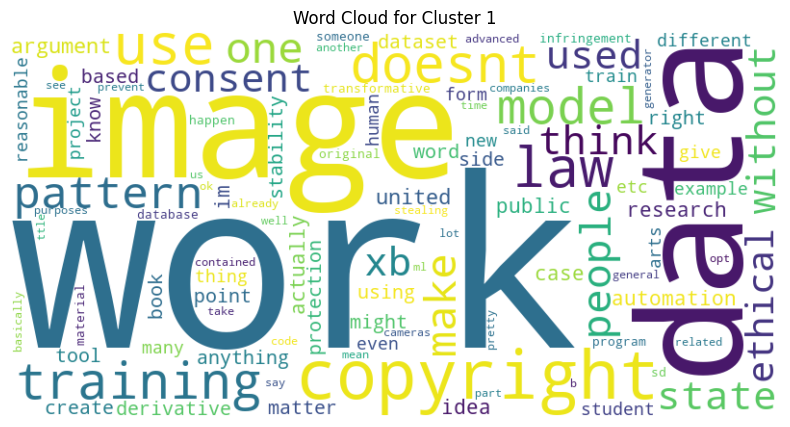


--- K-Means Cluster 2 ---
Number of docs: 212


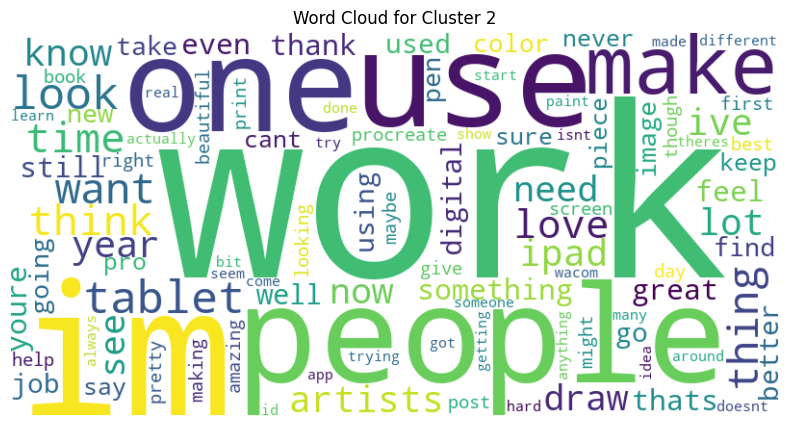


--- K-Means Cluster 3 ---
Number of docs: 481


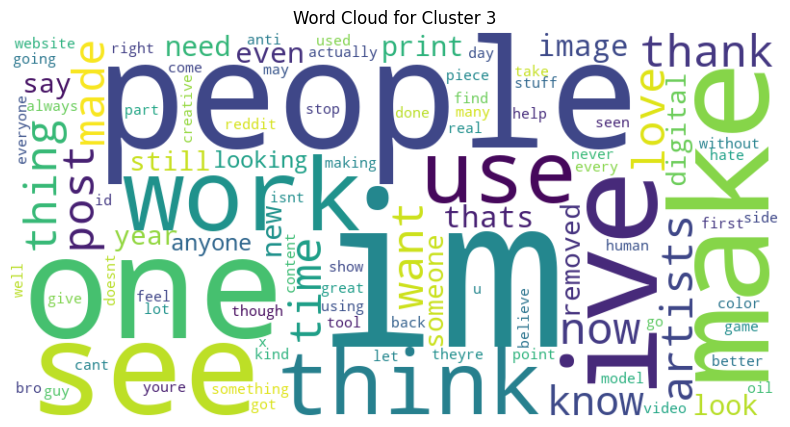

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Optionally, define additional stopwords if needed.
# For example:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["dont", "like", "just", "can", "will", "good", "really", "get", "way", "also", "much"])

# Loop through each cluster and generate a word cloud
for cluster in sorted(combined_df['KMeans_Cluster'].unique()):
    subset = combined_df[combined_df['KMeans_Cluster'] == cluster]
    print(f"\n--- K-Means Cluster {cluster} ---")
    print(f"Number of docs: {len(subset)}")

    # Combine all text from this cluster into one large string
    text = " ".join(subset['content'].tolist())

    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   stopwords=custom_stopwords,
                   max_words=100,
                   collocations=False)

    # Generate the word cloud from the text
    wc.generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Word Cloud for Cluster {cluster}")
    plt.axis("off")
    plt.show()


In [ ]:
aiart_path = "/Users/roryoflynn/Desktop/TEXT MINING/MOD1ASSGINMENT/LDF-NKW-AiArt.csv"
art_path   = "/Users/roryoflynn/Desktop/TEXT MINING/MOD1ASSGINMENT/LDF-NKW-Art.csv"

aiart_df = pd.read_csv(aiart_path)
art_df   = pd.read_csv(art_path)
art_df = art_df[['content']]
aiart_df = aiart_df[['content']]

#combine the two dfs
combined_df = pd.concat([art_df, aiart_df], ignore_index=True)
print("Total documents in combined data:", len(combined_df))

combined_df.sample(20)

Total documents in combined data: 703


,content
95,cheap options for an androidstandalone pen tab...
621,theres a bug in the android reddit app prevent...
288,randon heat fan
416,is antiart has always involved expression an...
237,digital i did on valentines day i love the c...
496,oh its alright when we do it
347,i enjoy utilizing to enhance my
38,christmas gift damo me oil on
213,how to deal with cmyk as an ibispaint user i d...
127,decided its time for a tablet need recs ive be...


In [ ]:
#turn art_df into a count vectorized Document term matrix and save as dtm
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(combined_df['content'])
vocab = vectorizer.get_feature_names_out()
print("Count Vectorizer shape:", dtm.shape)



Count Vectorizer shape: (703, 9226)


In [16]:
#print a sample of the dtm
dtm_df = pd.DataFrame(dtm.toarray(), columns=vocab)
print(dtm_df.sample(20))

     ____  _____  _liviiart  _my  _see_  abandoned  abbey  abd  abilities  \
86      0      0          0    0      0          0      0    0          0   
545     0      0          0    0      0          0      0    0          0   
266     0      0          0    0      0          0      0    0          0   
521     0      0          0    0      0          0      0    0          0   
580     0      0          0    0      0          0      0    0          0   
674     0      0          0    0      0          0      0    0          0   
636     0      0          0    0      0          0      0    0          0   
299     0      0          0    0      0          0      0    0          0   
671     0      0          0    0      0          0      0    0          0   
659     0      0          0    0      0          0      0    0          0   
505     0      0          0    0      0          0      0    0          0   
679     0      0          0    0      0          0      0    0          0   

In [ ]:
NUM_TOPICS = 10

lda_model = LatentDirichletAllocation(
    n_components=NUM_TOPICS,
    max_iter=10000,
    learning_method='online',
    random_state=42
)
lda_output = lda_model.fit_transform(dtm)

In [18]:
def print_topics(model, vectorizer, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:top_n]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx + 1}: {' '.join(top_features)}")

print("LDA Topics:")
print_topics(lda_model, vectorizer)

LDA Topics:
Topic 1: oil timelapse humor van rockwell platform morty spy norman engagement gogh portrait looks misunderstood closest goghs ermm ideogram jokes ruining
Topic 2: lmao nsfw anger uthedude_abides pinup sadness representative grief montage buff outline guns potter harry wife legit gta motherhood ricky rimandthisisdeep
Topic 3: people like just dont im make work think artists want use post time image images know really good ive need
Topic 4: removed digital asked grok disappointed dogg snoop smurf cyberpunk blue paddywack pale statement procreates manifesto mark prostest bryan trumpomatic learnimprove
Topic 5: red beginnings contest witch god knight chess skull black white tower detective gotham glamour dazzle bettering aboutnew thesubjectof beach adventures
Topic 6: flag unity wars american leonardo rainbow reaction alternate opposing acrylic wallpaper universe chunky human harassment pixar timeless bearwithcamera upstream jack
Topic 7: tablet ipad use pen procreate pro scre

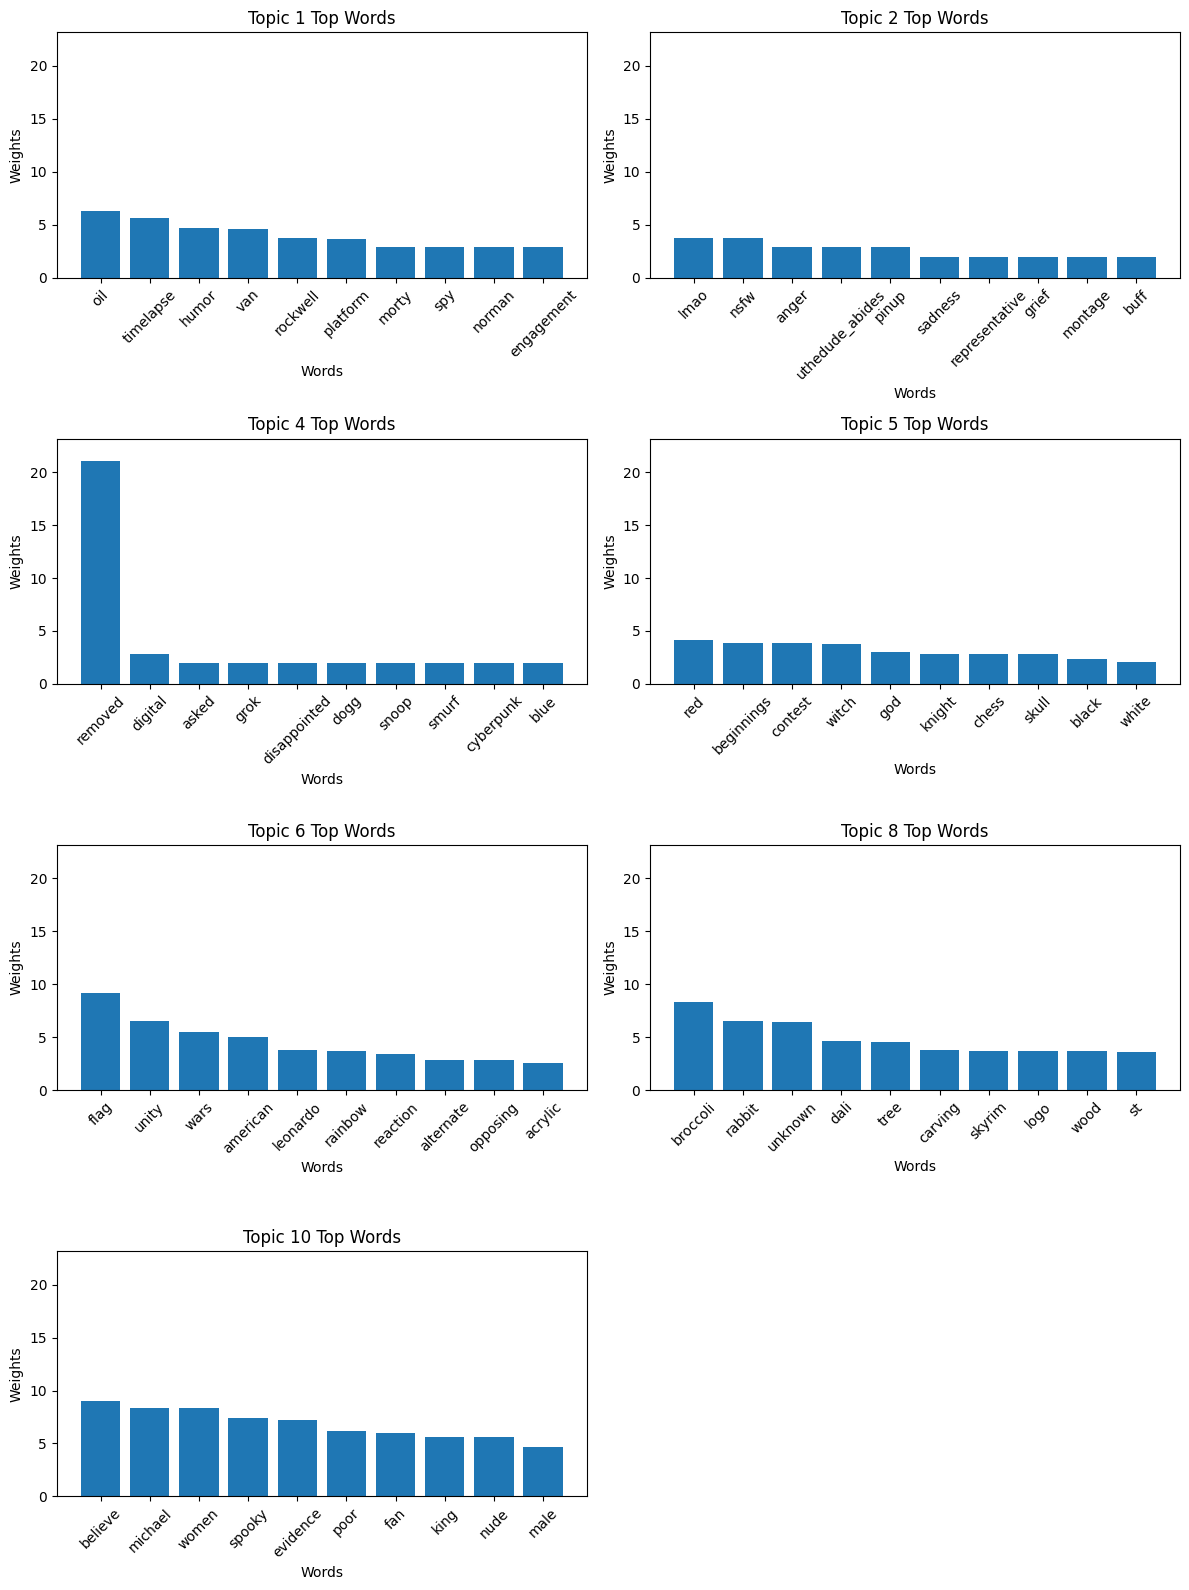

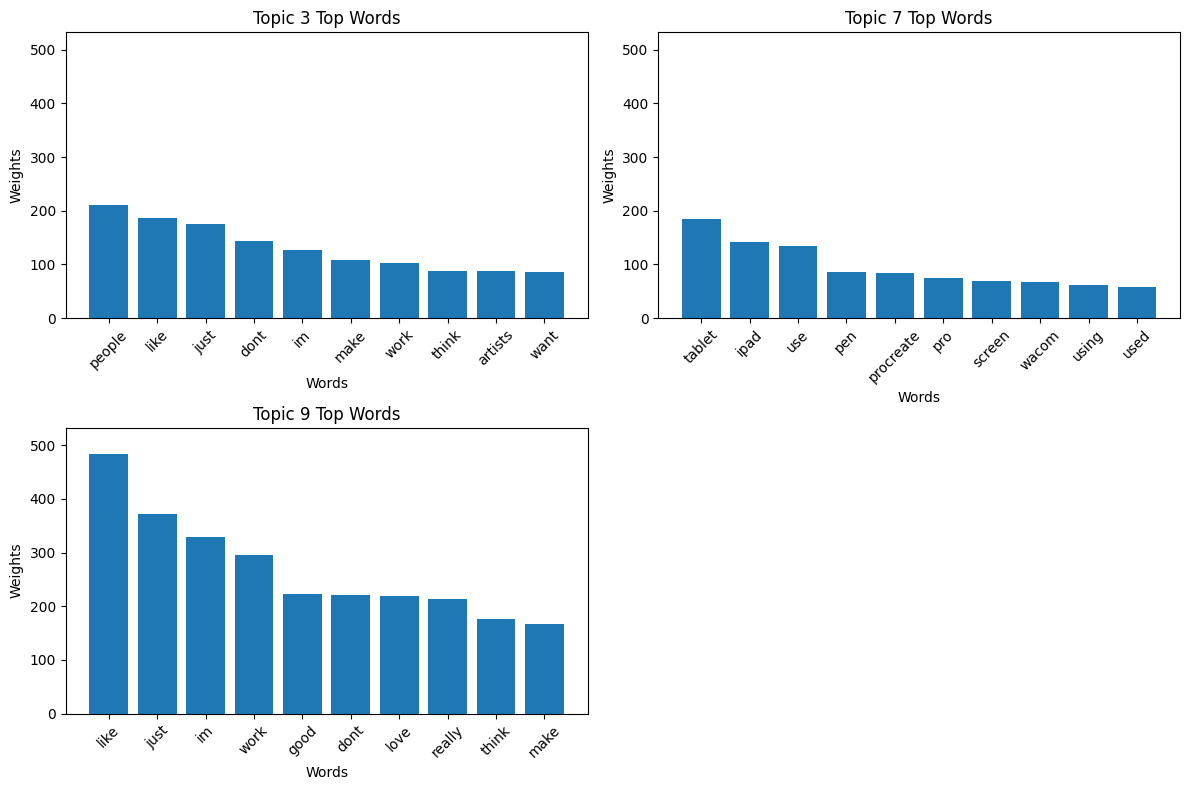

In [ ]:
import math
import matplotlib.pyplot as plt

num_topics = lda_model.components_.shape[0]
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()

# Define the outlier topis
outlier_indices = [2, 6, 8]

# Separate topics into normal and outlier groups
normal_topics = [i for i in range(num_topics) if i not in outlier_indices]
outlier_topics = outlier_indices

#standardized y-axis
global_max_normal = 0
for idx in normal_topics:
    topic = lda_model.components_[idx]
    top_indices = topic.argsort()[::-1][:num_top_words]
    top_values = topic[top_indices]
    if top_values.max() > global_max_normal:
        global_max_normal = top_values.max()

# Determine grid size for normal topics (2 columns)
n_cols_normal = 2 if len(normal_topics) > 1 else 1
n_rows_normal = math.ceil(len(normal_topics) / n_cols_normal)

fig_normal, axes_normal = plt.subplots(n_rows_normal, n_cols_normal, figsize=(n_cols_normal*6, n_rows_normal*4))
if len(normal_topics) == 1:
    axes_normal = [axes_normal]
else:
    axes_normal = axes_normal.flatten()

for j, idx in enumerate(normal_topics):
    ax = axes_normal[j]
    topic = lda_model.components_[idx]
    top_indices = topic.argsort()[::-1][:num_top_words]
    top_words = [feature_names[i] for i in top_indices]
    top_values = topic[top_indices]

    ax.bar(top_words, top_values)
    ax.set_xlabel("Words")
    ax.set_ylabel("Weights")
    ax.set_title(f"Topic {idx+1} Top Words")
    ax.set_ylim(0, global_max_normal * 1.1)  # standardized y-axis for normal topics
    ax.tick_params(axis='x', rotation=45)

# Remove any extra subplot axes for normal topics
for k in range(j+1, len(axes_normal)):
    fig_normal.delaxes(axes_normal[k])

fig_normal.tight_layout()
fig_normal.savefig("LDA_BarCharts_Normal.jpg")
plt.show()


#outlier chart
global_max_outlier = 0
for idx in outlier_topics:
    topic = lda_model.components_[idx]
    top_indices = topic.argsort()[::-1][:num_top_words]
    top_values = topic[top_indices]
    if top_values.max() > global_max_outlier:
        global_max_outlier = top_values.max()

n_outlier = len(outlier_topics)
n_cols_outlier = 2 if n_outlier > 1 else 1
n_rows_outlier = math.ceil(n_outlier / n_cols_outlier)

fig_outlier, axes_outlier = plt.subplots(n_rows_outlier, n_cols_outlier, figsize=(n_cols_outlier*6, n_rows_outlier*4))
if n_outlier == 1:
    axes_outlier = [axes_outlier]
else:
    axes_outlier = axes_outlier.flatten()

for j, idx in enumerate(outlier_topics):
    ax = axes_outlier[j]
    topic = lda_model.components_[idx]
    top_indices = topic.argsort()[::-1][:num_top_words]
    top_words = [feature_names[i] for i in top_indices]
    top_values = topic[top_indices]

    ax.bar(top_words, top_values)
    ax.set_xlabel("Words")
    ax.set_ylabel("Weights")
    ax.set_title(f"Topic {idx+1} Top Words")
    ax.set_ylim(0, global_max_outlier * 1.1)  # standardized y-axis for outlier topics
    ax.tick_params(axis='x', rotation=45)


for k in range(j+1, len(axes_outlier)):
    fig_outlier.delaxes(axes_outlier[k])

fig_outlier.tight_layout()
fig_outlier.savefig("LDA_BarCharts_Outliers.jpg")
plt.show()


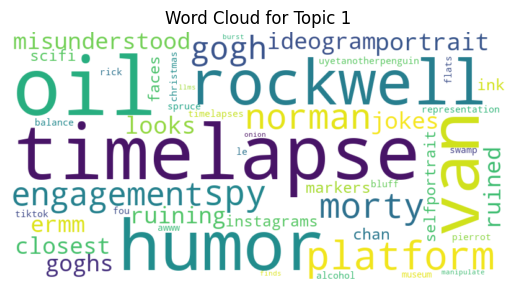

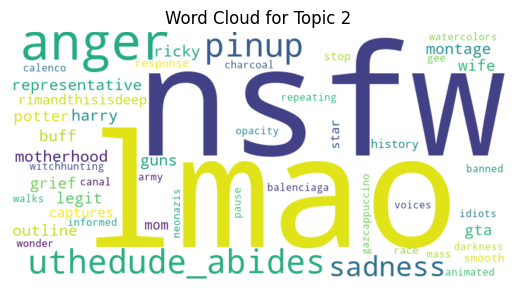

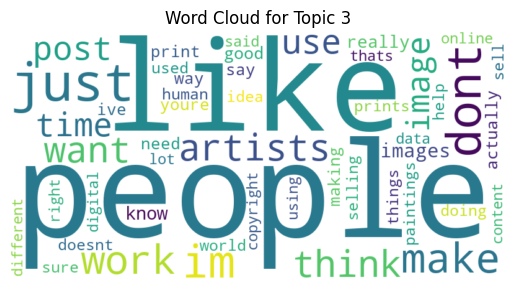

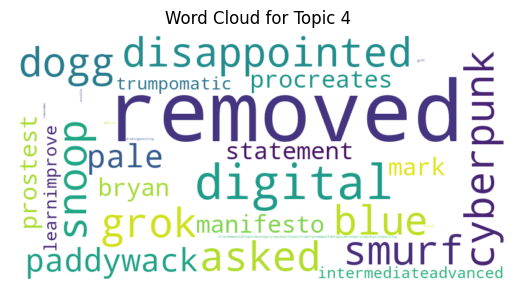

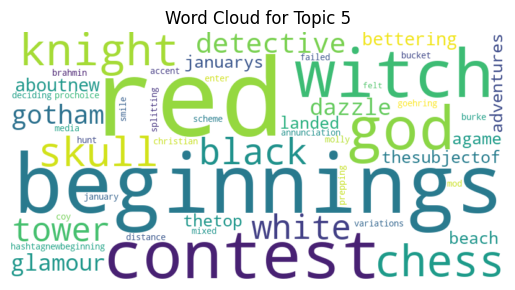

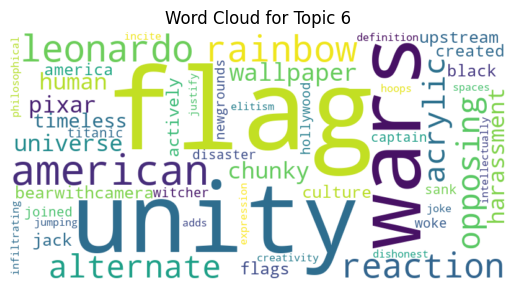

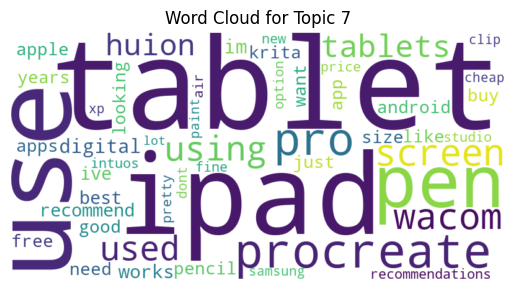

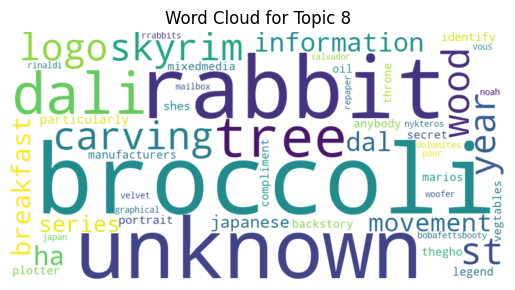

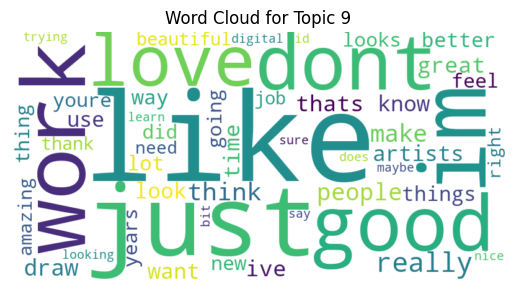

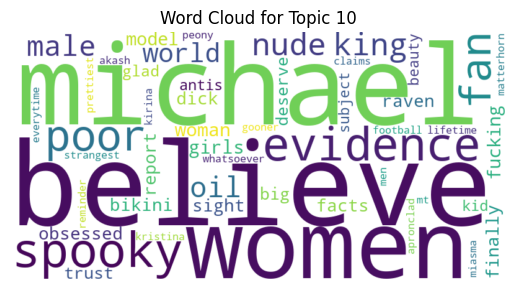

In [ ]:
for topic_idx, topic in enumerate(lda_model.components_):
    # Get the top 50 words for the topic
    top_indices = topic.argsort()[::-1][:50]
    topic_words = {feature_names[i]: topic[i] for i in top_indices}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx + 1}")
    plt.savefig(f"LDA_WordCloud_Topic{topic_idx + 1}.jpg")
    plt.show()

In [ ]:

warnings.filterwarnings("ignore", category=DeprecationWarning)

# --- Compute the inputs for pyLDAvis.prepare() ---

# 1. Topic-term distributions: normalize the LDA components.
topic_term_dists = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]

# 2. Document-topic distributions: use the output from LDA transform (already computed)
doc_topic_dists = lda_output  # Already computed via lda_model.fit_transform(DTM)

# 3. Document lengths: total word count per document from your original DTM.
doc_lengths = np.array(dtm.sum(axis=1)).flatten()

# 4. Vocabulary: get the feature names from your CountVectorizer.
vocab = vectorizer.get_feature_names_out()

# 5. Term frequency: total count of each term in the corpus from your original DTM.
term_frequency = np.array(dtm.sum(axis=0)).flatten()

# --- Prepare the visualization panel ---
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency, mds='tsne')

# Save the interactive visualization to an HTML file.
pyLDAvis.save_html(panel, "LDA_Interactive_Visualization.html")
print("pyLDAvis HTML file saved as 'LDA_Interactive_Visualization.html'.")


pyLDAvis HTML file saved as 'LDA_Interactive_Visualization.html'.


In [ ]:

pyLDAvis.display(panel)
